Dadas las series temporales obtenidas de MeteoCdG (meteocdg.uca.es) para el periodo 24-04 al 30-04, a las que se les han borrado datos. Se pide:

- Reconstruir la serie de datos de la forma más precisa posible.
- Tasar el error cometido en la reconstrucción con el MAE y RMSE, usando como referencia la serie de datos completa. Realice ambos estadísticos tanto para la serie completa como para los datos reconstruidos exclusivamente.
- Informe en el que se explique el procesado o técnica empleada y su justificación.

Puedes usar todas las variables y estaciones meteorológicas de MeteoCdG que consideres necesarias, excepto de la estación a completar.

In [1]:
using Pkg

Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ayats\Documents\ici-reconstruct`


In [2]:
using CSV, DataFrames, DataFramesMeta
import Dates

rsp_df = @chain CSV.read(
    "data/Temperatura de Río San Pedro desde 2023-04-24 hasta 2023-04-30 - missingdata.csv",
    DataFrame;
    normalizenames=true,
    dateformat="yyyy-mm-dd HH:MM:SS",
) begin
    @select(:ts, :temp = :Temperatura_ºC_)
    @transform(@byrow :ts_unix = Dates.datetime2unix(:ts))
end

Row,ts,temp,ts_unix
,DateTime,Float64,Float64
1,2023-04-24T00:00:00,18.45,1.68229e9
2,2023-04-24T00:10:00,18.55,1.6823e9
3,2023-04-24T00:20:00,18.45,1.6823e9
4,2023-04-24T00:30:00,17.93,1.6823e9
5,2023-04-24T00:40:00,17.39,1.6823e9
6,2023-04-24T00:50:00,17.1,1.6823e9
7,2023-04-24T01:00:00,17.04,1.6823e9
8,2023-04-24T01:10:00,16.97,1.6823e9
9,2023-04-24T01:20:00,16.97,1.6823e9


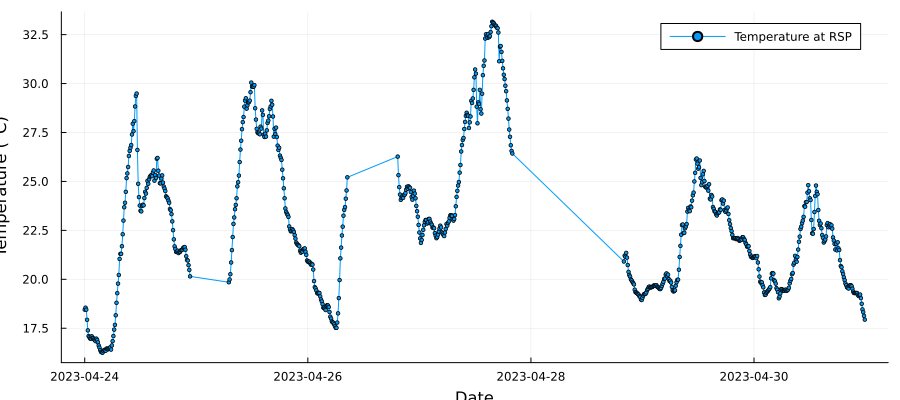

In [3]:
using StatsPlots

@df rsp_df plot(:ts, :temp, label="Temperature at RSP", marker=:circle, markersize=2)
xlabel!("Date")
ylabel!("Temperature (°C)")
plot!(size=(900,400))

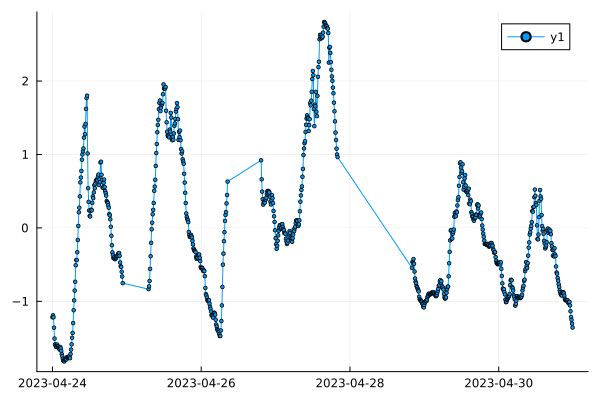

In [4]:
using Statistics

rsp_mean = mean(rsp_df[:, :temp])
rsp_std = std(rsp_df[:, :temp])
@transform!(rsp_df, @byrow :temp_norm = (:temp - rsp_mean) / rsp_std)

@df rsp_df plot(:ts, :temp_norm, marker=:circle, markersize=2)

Row,ts,temp_norm
,DateTime,Float64
1,2023-04-24T00:00:00,-1.21706
2,2023-04-24T00:10:00,-1.18972
3,2023-04-24T00:20:00,-1.21706
4,2023-04-24T00:30:00,-1.35921
5,2023-04-24T00:40:00,-1.50682
6,2023-04-24T00:50:00,-1.5861
7,2023-04-24T01:00:00,-1.6025
8,2023-04-24T01:10:00,-1.62163
9,2023-04-24T01:20:00,-1.62163


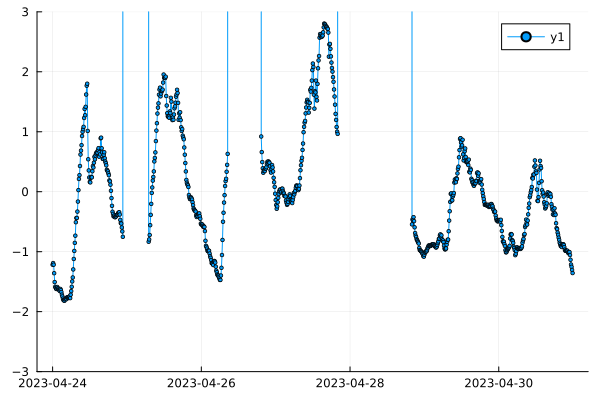

In [131]:
rsp_resampled_df = DataFrame(ts=range(
    rsp_df[:, :ts] |> minimum,
    rsp_df[:, :ts] |> maximum,
    step=Dates.Minute(10)
))

# rsp_resampled_df = first(rsp_resampled_df, 2)


@transform!(rsp_resampled_df, @byrow :temp_norm = begin
    same_time = filter(row -> row.ts == :ts, rsp_df, view=true)

    if nrow(same_time) == 1
        return same_time.temp_norm[1]
    else
        return 1e6
    end
end)


display(rsp_resampled_df)

@df rsp_resampled_df plot(:ts, :temp_norm, marker=:circle, markersize=2)
using Plots
ylims!((-3,3))

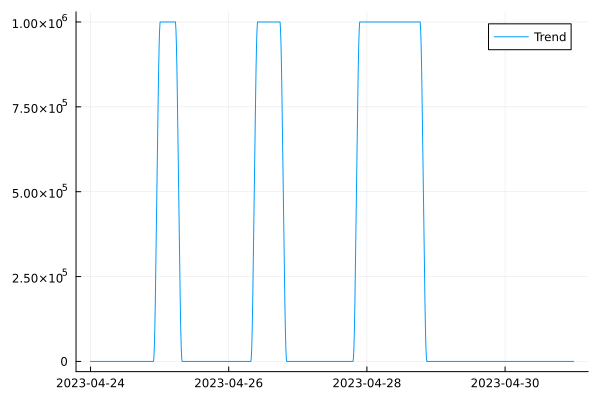

In [132]:
import SingularSpectrumAnalysis as SSA

trend, season = SSA.analyze(
    rsp_resampled_df[:, :temp_norm],
    10,
    robust=true
) 

plot(rsp_resampled_df[:, :ts], trend, label="Trend",)